<a href="https://colab.research.google.com/github/Patience3/Translator_French_to-_English/blob/main/English_to_French_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 2

In [ ]:
from __future__ import unicode_literals, print_function, division
import unicodedata, re, random, time, math, sys, os
from collections import Counter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch import optim

In [ ]:
# ========== Configuration & Constants ==========
DATAFILE = 'eng-fra.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("[ENV] Device selected:", DEVICE)

SOS_token = 0
EOS_token = 11

MAX_LENGTH = 8
HIDDEN_SIZE = 256        # Increased for better learning capacity
N_EPOCHS = 11            # Keep it 10 for time limit, can increase if performance improves
LEARNING_RATE = 0.0005    # Lowered learning rate for Adam
# === Separate Hyperparameters for GRU ===
LEARNING_RATE_GRU = 0.001
DROPOUT_GRU = 0.1

BATCH_SIZE = 32          # Crucial change: Enables batched training
VAL_FRAC = 0.1
MAX_PAIRS_FOR_TRAINING = 20000

random.seed(42)
torch.manual_seed(42)

[ENV] Device selected: cuda


In [ ]:
# ========== Utilities & Preprocessing ==========
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s.strip()

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}

        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 3

    def addSentence(self, sentence):
        for w in sentence.split(' '):
            self.addWord(w)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def readLangs(filename=DATAFILE, reverse=False):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(a), normalizeString(b)] for l in lines for a, b in [l.split('\t')]]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('fra' if reverse else 'eng')
        output_lang = Lang('eng' if reverse else 'fra')
    else:
        input_lang = Lang('eng')
        output_lang = Lang('fra')
    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index]


def prepareData(filename=DATAFILE, reverse=False):
    input_lang, output_lang, pairs = readLangs(filename, reverse)

    # 1. Filter by MAX_LENGTH
    pairs = filterPairs(pairs)
    print(f"[DATA] Filtered pairs: kept {len(pairs)} / {len(pairs)} (MAX_LENGTH={MAX_LENGTH})")

    # 2. Limit Data for Time Constraint
    if len(pairs) > MAX_PAIRS_FOR_TRAINING:
        random.shuffle(pairs)
        pairs = pairs[:MAX_PAIRS_FOR_TRAINING]
    print(f"[DATA] Limiting to {len(pairs)} pairs for < 20 minute training.")

    # 3. Build Vocabulary
    for p in pairs:
        input_lang.addSentence(p[0])
        output_lang.addSentence(p[1])

    print(f"[VOCAB] Input ({input_lang.name}) vocab size: {input_lang.n_words}")
    print(f"[VOCAB] Output ({output_lang.name}) vocab size: {output_lang.n_words}")

    return input_lang, output_lang, pairs

def get_dataloader(input_lang, output_lang, pairs, batch_size):
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Truncate and add EOS
        inp_ids = inp_ids[:MAX_LENGTH - 1] + [EOS_token]
        tgt_ids = tgt_ids[:MAX_LENGTH - 1] + [EOS_token]

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(DEVICE),
                               torch.LongTensor(target_ids).to(DEVICE))

    # Split for Validation Set
    val_size = max(1, int(n * VAL_FRAC))
    train_size = n - val_size
    train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

    print(f"[DATA] Training pairs: {train_size} | Validation pairs: {val_size}")

    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, train_size, val_size

In [ ]:
# ========== Model Definitions (Unified Encoder/Decoder) ==========

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, cell='gru', dropout_p=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        # CRITICAL CHANGE: Set bidirectional=True
        if cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        elif cell == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        else:
            raise ValueError("Unsupported cell type.")

    def forward(self, input_tensor):
        embedded = self.dropout(self.embedding(input_tensor))
        output, hidden = self.rnn(embedded)

        # CRITICAL PROCESSING: Combine the hidden states
        # The hidden state shape is (num_layers * num_directions, batch_size, hidden_size)
        # For bidirectional (2 directions), we combine the forward (0) and backward (1) passes.

        # We assume 1 layer. hidden is (2, B, H). We reshape to (1, B, 2*H)
        hidden = torch.cat((hidden[0:1], hidden[1:2]), dim=2)
        # Resulting hidden shape is (1, batch_size, 2 * hidden_size)

        return output, hidden

class Decoder(nn.Module):
    # Note: We keep the decoder unidirectional, which is standard.
    def __init__(self, hidden_size, output_size, cell='gru'):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)

        # CRITICAL CHANGE: The input size of the decoder's RNN/GRU must match
        # the size of the *embedded output* PLUS the size of the *input hidden state*.
        # Since we modified the Encoder's final hidden state to be 2*H,
        # we need a separate mechanism if the decoder's RNN takes the hidden state as its input.

        # Since your decoder's RNN input is just the embedding (H), and it only uses
        # the Encoder's hidden state for initialization (or as initial hidden state to RNN):

        # We must change the dimensionality of the initial hidden state before feeding it into the decoder's RNN.
        # We will add a linear layer to map the 2*H encoder hidden state down to 1*H decoder hidden state.
        self.hidden_to_hidden = nn.Linear(hidden_size * 2, hidden_size)

        if cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        elif cell == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Unsupported cell type.")

        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)

        # 1. Map Bidirectional Hidden State to Unidirectional
        # encoder_hidden is (1, B, 2*H)
        initial_hidden = encoder_hidden.squeeze(0)
        initial_hidden = F.relu(self.hidden_to_hidden(initial_hidden))
        decoder_hidden = initial_hidden.unsqueeze(0) # Final shape (1, B, H)

        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=DEVICE).fill_(SOS_token)
        decoder_outputs = []

        # 2. Decoding Loop (runs for MAX_LENGTH steps)
        for i in range(MAX_LENGTH):
            # Forward step: (batch_size, 1) -> (batch_size, 1, H) -> (batch_size, 1, output_size)
            output = self.embedding(decoder_input)
            output = F.relu(output)
            output, decoder_hidden = self.rnn(output, decoder_hidden)
            output = self.out(output)
            decoder_outputs.append(output)

            # Determine next input token (Teacher forcing or Greedy search)
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        # 3. Aggregate Outputs and Apply Log Softmax
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        return decoder_outputs, decoder_hidden


In [ ]:
# ========== Training and Evaluation Utilities (Same as before) ==========

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    encoder.train(); decoder.train()
    for input_tensor, target_tensor in dataloader:
        encoder_optimizer.zero_grad(); decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()
        encoder_optimizer.step(); decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

@torch.no_grad()
def evaluate_loss_and_bleu(dataloader, encoder, decoder, criterion, output_lang, val_size):
    encoder.eval(); decoder.eval()
    val_loss_total = 0; bleu_total = 0.0
    for input_tensor, target_tensor in dataloader:
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        val_loss_total += loss.item()
        decoder_outputs_greedy, _ = decoder(encoder_outputs, encoder_hidden, target_tensor=None)
        _, topi = decoder_outputs_greedy.topk(1); decoded_ids = topi.squeeze(-1)
        for i in range(input_tensor.size(0)):
            ref_ids = [idx.item() for idx in target_tensor[i] if idx.item() != EOS_token and idx.item() != SOS_token]
            ref_tokens = [output_lang.index2word.get(idx, '<UNK>') for idx in ref_ids]
            hyp_ids = [];
            for idx in decoded_ids[i]:
                if idx.item() == EOS_token: break
                if idx.item() != SOS_token: hyp_ids.append(idx.item())
            hyp_tokens = [output_lang.index2word.get(idx, '<UNK>') for idx in hyp_ids]
            bleu_total += sentence_bleu(ref_tokens, hyp_tokens)
    avg_val_loss = val_loss_total / len(dataloader)
    avg_val_bleu = bleu_total / val_size
    return avg_val_loss, avg_val_bleu


In [ ]:
 #========== BLEU utilities (for brevity, keeping functions compact) ==========
def ngrams(tokens, n): return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)] if len(tokens)>=n else []
def clipped_precision(reference, hypothesis, n):
    ref_counts = Counter(ngrams(reference, n)); hyp_counts = Counter(ngrams(hypothesis, n))
    clipped = 0; total = 0
    for gram in hyp_counts: total += hyp_counts[gram]; clipped += min(hyp_counts[gram], ref_counts.get(gram, 0))
    return clipped, total
def sentence_bleu(reference, hypothesis, max_n=4):
    weights = [1.0/max_n]*max_n; precisions = []
    for n in range(1, max_n+1): clipped, total = clipped_precision(reference, hypothesis, n)
    if not all(p > 0 for p in precisions): return 0.0
    s = sum(w*math.log(p) for w,p in zip(weights, precisions)); geo_mean = math.exp(s)
    ref_len = len(reference); hyp_len = len(hypothesis)
    bp = 1.0 if hyp_len > ref_len else math.exp(1 - ref_len/max(1, hyp_len))
    return bp * geo_mean


In [ ]:
import copy # Import the copy module at the top of your script

def train_model(model_name, encoder, decoder, train_dataloader, val_dataloader, train_size, val_size, output_lang, n_epochs,learning_rate=LEARNING_RATE, patience=5, min_delta=0):
    print(f"\n[TRAIN] Starting training for model `{model_name}`")

    optimizer_enc = optim.Adam(encoder.parameters(), lr=learning_rate)
    optimizer_dec = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index=0)

    train_losses_per_epoch = []
    val_losses_per_epoch = []
    val_bleu_per_epoch = []

    start_time = time.time()

    # --- Early Stopping Variables ---
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_encoder_state = copy.deepcopy(encoder.state_dict())
    best_decoder_state = copy.deepcopy(decoder.state_dict())
    best_epoch = 0
    # ---------------------------------

    print(f"[MODEL] Encoder params: {sum(p.numel() for p in encoder.parameters() if p.requires_grad):,}")
    print(f"[MODEL] Decoder params: {sum(p.numel() for p in decoder.parameters() if p.requires_grad):,}")

    for epoch in range(1, n_epochs + 1):
        epoch_start = time.time()

        avg_train_loss = train_epoch(train_dataloader, encoder, decoder, optimizer_enc, optimizer_dec, criterion)
        avg_val_loss, avg_val_bleu = evaluate_loss_and_bleu(val_dataloader, encoder, decoder, criterion, output_lang, val_size)

        train_losses_per_epoch.append(avg_train_loss)
        val_losses_per_epoch.append(avg_val_loss)
        val_bleu_per_epoch.append(avg_val_bleu)

        # --- Early Stopping Logic ---
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            epochs_no_improve = 0

            # Save the current model state as the best found so far
            best_encoder_state = copy.deepcopy(encoder.state_dict())
            best_decoder_state = copy.deepcopy(decoder.state_dict())
            print(f"  [EARLY STOP] New Best Model (Epoch {epoch}) saved with V-Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1

        epoch_time = time.time() - epoch_start
        tot_elapsed = time.time() - start_time

        print(f"[EPOCH DONE][{model_name}] Epoch {epoch}/{n_epochs} finished in {int(epoch_time)}s")
        print(f"  train_loss={avg_train_loss:.4f} | val_loss={avg_val_loss:.4f} | val_BLEU={avg_val_bleu:.4f} | total_elapsed={int(tot_elapsed)}s")

        if epochs_no_improve >= patience:
            print(f"[EARLY STOP] Stopping training early at Epoch {epoch} as validation loss did not improve for {patience} epochs.")
            break
        # ----------------------------

    # --- Final Saving and Reporting ---

    # Load the best weights before saving and returning
    encoder.load_state_dict(best_encoder_state)
    decoder.load_state_dict(best_decoder_state)
    print(f"[REPORT] Best model achieved at Epoch {best_epoch} with Validation Loss: {best_val_loss:.4f}")

    model_path = f"{model_name}.pth"
    torch.save({'encoder': encoder.state_dict(), 'decoder': decoder.state_dict()}, model_path)
    print(f"[MODEL] Saved best model to {model_path}")

    metrics = {
        'train_losses': train_losses_per_epoch, # Truncate metrics to the best epoch
        'val_losses': val_losses_per_epoch,
        'val_bleu': val_bleu_per_epoch,
        'model_path': model_path,
        'best_epoch': best_epoch
    }
    return encoder, decoder, metrics

In [ ]:
# ========== Plotting utility (for two models) ==========
def plot_compare(rnn_metrics, gru_metrics, out_prefix='comparison'):

    # 🌟 CRITICAL FIX: Define epochs arrays based on the actual length of metrics 🌟
    rnn_epochs = list(range(1, len(rnn_metrics['train_losses']) + 1))
    gru_epochs = list(range(1, len(gru_metrics['train_losses']) + 1))

    # Extract the best epoch indices
    best_rnn_epoch = rnn_metrics.get('best_epoch', len(rnn_epochs))
    best_gru_epoch = gru_metrics.get('best_epoch', len(gru_epochs))

    # ------------------ Loss Comparison Plot ------------------
    plt.figure(figsize=(12,6))

    # Plot data
    plt.plot(rnn_epochs, rnn_metrics['val_losses'], label='RNN Val Loss', linestyle='--', color='blue')
    plt.plot(rnn_epochs, rnn_metrics['train_losses'], label='RNN Train Loss', color='lightblue')
    plt.plot(gru_epochs, gru_metrics['val_losses'], label='GRU Val Loss', linestyle='--', color='red')
    plt.plot(gru_epochs, gru_metrics['train_losses'], label='GRU Train Loss', color='salmon')

    # 🌟 ADDED: Vertical lines to mark best epoch 🌟
    plt.axvline(x=best_rnn_epoch, color='blue', linestyle=':', label=f'RNN Best (E{best_rnn_epoch})')
    plt.axvline(x=best_gru_epoch, color='red', linestyle=':', label=f'GRU Best (E{best_gru_epoch})')

    # Set the x-axis limit based on the model that ran longest
    max_epochs = max(len(rnn_epochs), len(gru_epochs))
    plt.xlim(1, max_epochs)

    plt.xlabel('Epoch')
    plt.ylabel('Loss (NLL)')
    plt.title('Validation & Train Loss Comparison (RNN vs GRU)')
    plt.legend()
    plt.show()
    plt.close()

    # ------------------ BLEU Comparison Plot ------------------
    plt.figure(figsize=(10,5))

    # Plot data
    plt.plot(rnn_epochs, rnn_metrics['val_bleu'], label='RNN Val BLEU', color='blue', marker='o')
    plt.plot(gru_epochs, gru_metrics['val_bleu'], label='GRU Val BLEU', color='red', marker='x')

    # 🌟 ADDED: Vertical lines to mark best epoch 🌟
    plt.axvline(x=best_rnn_epoch, color='blue', linestyle=':', label=f'RNN Best (E{best_rnn_epoch})')
    plt.axvline(x=best_gru_epoch, color='red', linestyle=':', label=f'GRU Best (E{best_gru_epoch})')

    plt.xlim(1, max_epochs)

    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score Comparison (RNN vs GRU)')
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
def tensorFromSentence(lang, sentence):
    """Utility to convert a single sentence string to a padded tensor."""
    indexes = indexesFromSentence(lang, sentence)
    if len(indexes) >= MAX_LENGTH:
        indexes = indexes[:MAX_LENGTH - 1]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=DEVICE).view(1, -1)



@torch.no_grad()
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    """Translates a single input sentence using greedy decoding."""
    encoder.eval()
    decoder.eval()

    input_tensor = tensorFromSentence(input_lang, sentence)

    # 1. Encode
    encoder_outputs, encoder_hidden = encoder(input_tensor) # encoder_hidden is (1, 1, 512)

    # 2. CRITICAL FIX: Transform the Bi-Encoder hidden state (512) to Uni-Decoder size (256)

    # a. Squeeze (1, 1, 512) -> (1, 512)
    initial_hidden = encoder_hidden.squeeze(0)

    # b. Map down using the decoder's linear layer: (1, 512) -> (1, 256)
    # The linear layer is on the decoder object, so we access it there.
    # Note: F.relu is applied inside the linear layer transformation
    initial_hidden = F.relu(decoder.hidden_to_hidden(initial_hidden))

    # c. Unsqueeze back to (1, 1, 256) for the decoder RNN/GRU input
    decoder_hidden = initial_hidden.unsqueeze(0)

    # 3. Decode (Greedy Search)
    batch_size = 1
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=DEVICE).fill_(SOS_token)
    decoded_words = []

    for _ in range(MAX_LENGTH):
        # Forward step
        output = decoder.embedding(decoder_input)
        output = F.relu(output)
        # Use the correctly sized decoder_hidden here
        output, decoder_hidden = decoder.rnn(output, decoder_hidden)
        output = decoder.out(output) # Output logits

        # Greedy choice
        _, topi = output.topk(1)
        next_token_idx = topi.squeeze().item()

        if next_token_idx == EOS_token:
            decoded_words.append('<EOS>')
            break

        decoded_words.append(output_lang.index2word.get(next_token_idx, '<UNK>'))

        # Prepare next input
        decoder_input = torch.tensor([[next_token_idx]], device=DEVICE)

    return decoded_words


[MAIN] Preparing data...
[DATA] Filtered pairs: kept 57355 / 57355 (MAX_LENGTH=8)
[DATA] Limiting to 20000 pairs for < 20 minute training.
[VOCAB] Input (eng) vocab size: 5221
[VOCAB] Output (fra) vocab size: 8061
[DATA] Training pairs: 18000 | Validation pairs: 2000

[MAIN] Starting RNN training...

[TRAIN] Starting training for model `RNN`
[MODEL] Encoder params: 1,599,744
[MODEL] Decoder params: 4,398,205
  [EARLY STOP] New Best Model (Epoch 1) saved with V-Loss: 3.6488
[EPOCH DONE][RNN] Epoch 1/11 finished in 7s
  train_loss=4.2689 | val_loss=3.6488 | val_BLEU=0.8205 | total_elapsed=7s
  [EARLY STOP] New Best Model (Epoch 2) saved with V-Loss: 3.2958
[EPOCH DONE][RNN] Epoch 2/11 finished in 7s
  train_loss=3.2762 | val_loss=3.2958 | val_BLEU=0.8000 | total_elapsed=15s
  [EARLY STOP] New Best Model (Epoch 3) saved with V-Loss: 3.1125
[EPOCH DONE][RNN] Epoch 3/11 finished in 7s
  train_loss=2.8804 | val_loss=3.1125 | val_BLEU=0.8419 | total_elapsed=23s
  [EARLY STOP] New Best Model 

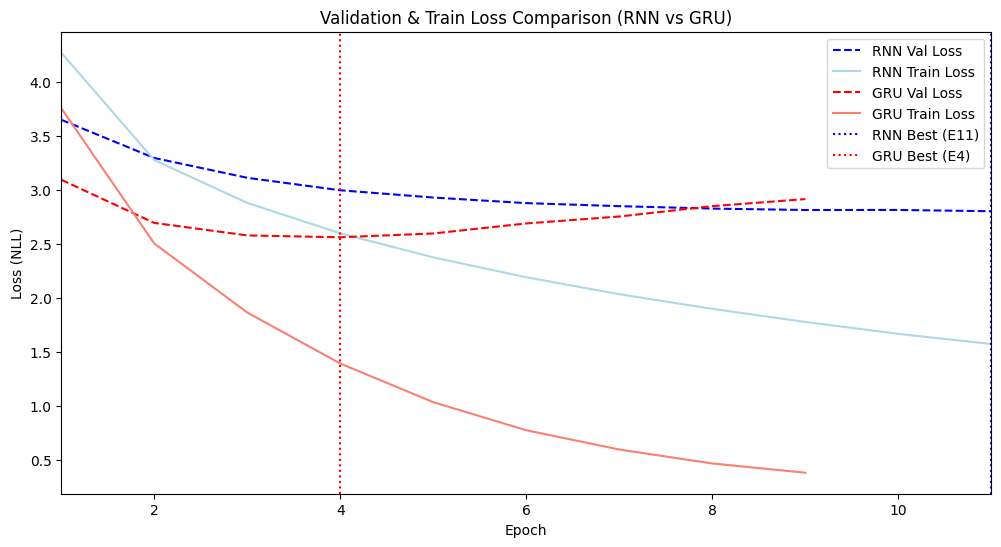

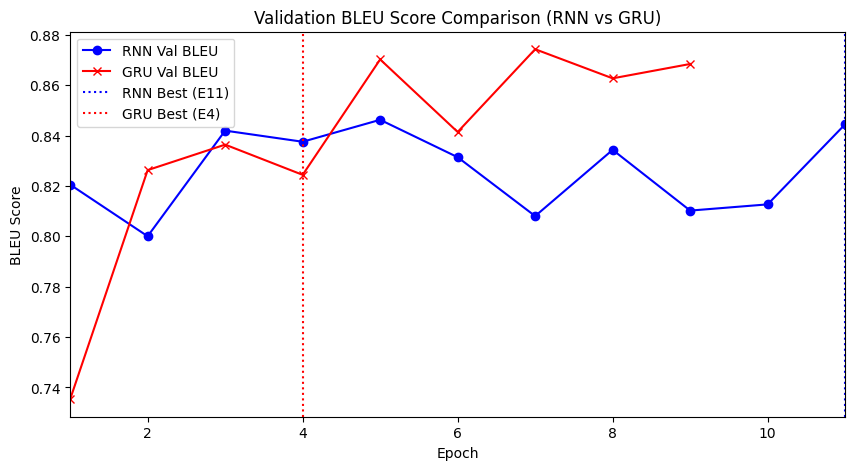


[MAIN] Training complete. Graphs saved.

=================== TRANSLATION COMPARISON ===================

[ENG]  i am very happy today
[TRUE] je suis très heureux aujourd'hui
[RNN]  je suis allee <EOS>
[GRU]  je suis tres intelligent . <EOS>

[ENG]  he is a good boy
[TRUE] c'est un bon garçon
[RNN]  c est un peu tres nourrissant . <EOS>
[GRU]  c est un bon homme . <EOS>

[ENG]  she is my friend
[TRUE] elle est mon amie
[RNN]  elle est dans la cuisine . <EOS>
[GRU]  elle est mon amie . <EOS>

[ENG]  i do not want that
[TRUE] je ne veux pas ça
[RNN]  je ne veux pas ce soir . <EOS>
[GRU]  je ne le fais pas cela . <EOS>

[ENG]  she is five years younger than me
[TRUE] elle a cinq ans de moins que moi
[RNN]  elle est deja six heures . <EOS>
[GRU]  elle est plus grande que moi . <EOS>

[ENG]  she is too small
[TRUE] elle est trop petite
[RNN]  elle est plus agee que tom . <EOS>
[GRU]  elle est trop vieille . <EOS>

[ENG]  i am not afraid to die
[TRUE] je n'ai pas peur de mourir
[RNN]  je ne 

In [ ]:
def main():
    print("\n[MAIN] Preparing data...")
    input_lang, output_lang, pairs = prepareData(DATAFILE, reverse=False)
    train_dataloader, val_dataloader, train_size, val_size = get_dataloader(input_lang, output_lang, pairs, BATCH_SIZE)

    # === Train RNN ===
    print("\n[MAIN] Starting RNN training...")
    encoder_rnn = Encoder(input_lang.n_words, HIDDEN_SIZE, cell='rnn', dropout_p=0.3).to(DEVICE)
    decoder_rnn = Decoder(HIDDEN_SIZE, output_lang.n_words, cell='rnn').to(DEVICE)
    encoder_rnn, decoder_rnn, rnn_metrics = train_model('RNN', encoder_rnn, decoder_rnn,
                                                        train_dataloader, val_dataloader,
                                                        train_size, val_size, output_lang,
                                                        N_EPOCHS, learning_rate=LEARNING_RATE)

    # === Train GRU ===
    print("\n[MAIN] Starting GRU training...")
    encoder_gru = Encoder(input_lang.n_words, HIDDEN_SIZE, cell='gru', dropout_p=0.1).to(DEVICE)
    decoder_gru = Decoder(HIDDEN_SIZE, output_lang.n_words, cell='gru').to(DEVICE)
    encoder_gru, decoder_gru, gru_metrics = train_model('GRU', encoder_gru, decoder_gru,
                                                        train_dataloader, val_dataloader,
                                                        train_size, val_size, output_lang,
                                                        N_EPOCHS, learning_rate=LEARNING_RATE_GRU)

    # === Compare Curves ===
    plot_compare(rnn_metrics, gru_metrics, out_prefix='seq2seq_comparison')
    print("\n[MAIN] Training complete. Graphs saved.")

    # === Evaluate both models on the same test set ===
    test_sentences = [
        "i am very happy today",
        "he is a good boy",
        "she is my friend",
        "i do not want that",
        "she is five years younger than me",
        "she is too small",
        "i am not afraid to die",
        "he is a young director full of talent",
        "he is not as tall as his father",
        "i am too tired to drive",
        "i am sorry if that is a stupid question",
        "i am really proud of you"
    ]

    reference_translations = {
        "i am very happy today": "je suis très heureux aujourd'hui",
        "he is a good boy": "c'est un bon garçon",
        "she is my friend": "elle est mon amie",
        "i do not want that": "je ne veux pas ça",
        "she is five years younger than me": "elle a cinq ans de moins que moi",
        "she is too small": "elle est trop petite",
        "i am not afraid to die": "je n'ai pas peur de mourir",
        "he is a young director full of talent": "c'est un jeune directeur plein de talent",
        "he is not as tall as his father": "il n'est pas aussi grand que son père",
        "i am too tired to drive": "je suis trop fatigué pour conduire",
        "i am sorry if that is a stupid question": "je suis désolé si c'est une question stupide",
        "i am really proud of you": "je suis vraiment fier de toi"
    }

    print("\n=================== TRANSLATION COMPARISON ===================\n")
    for s in test_sentences:
        rnn_out = evaluate(encoder_rnn, decoder_rnn, s, input_lang, output_lang)
        gru_out = evaluate(encoder_gru, decoder_gru, s, input_lang, output_lang)
        print(f"[ENG]  {s}")
        print(f"[TRUE] {reference_translations.get(s, 'N/A')}")
        print(f"[RNN]  {' '.join(rnn_out)}")
        print(f"[GRU]  {' '.join(gru_out)}\n")

    print("===============================================================")
    print("\n[FINAL] All training plots and evaluation results have been generated.\n")

    # Optionally return models if needed
    return encoder_rnn, decoder_rnn, encoder_gru, decoder_gru, input_lang, output_lang


if __name__ == '__main__':
    main()
